<a href="https://colab.research.google.com/github/arpan-das-astrophysics/LangChain-Vector-Databases-in-Production-Activeloop/blob/main/Project03_Build_a_Customer_Support_Question_Answering_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Build a Customer Support Question Answering Chatbot**

## **Introduction**
As we witness accelerated technological progress, large language models like GPT-4 and ChatGPT have emerged as significant breakthroughs in the tech landscape. These state-of-the-art models demonstrate exceptional prowess in content generation. However, they are not without their share of challenges, such as biases and hallucinations. Despite these limitations, LLMs have the potential to bring about a transformative impact on chatbot development.

Traditional, primarily intent-based chatbots have been designed to respond to specific user intents. These intents comprise a collection of sample questions and corresponding responses. For instance, a "Restaurant Recommendations" intent might include sample questions like "Can you suggest a good Italian restaurant nearby?" or "Where can I find the best sushi in town?" with responses such as "You can try the Italian restaurant 'La Trattoria' nearby" or "The top-rated sushi place in town is 'Sushi Palace.'"

When users interact with the chatbot, their queries are matched to the most similar intent, generating the associated response. However, as LLMs continue to evolve, chatbot development is shifting toward more sophisticated and dynamic solutions capable of handling a broader range of user inquiries with greater precision and nuance.

## **Having a Knowledge Base**
LLMs can significantly enhance chatbot functionality by associating broader intents with documents from a Knowledge Base (KB) instead of specific questions and answers. This approach streamlines intent management and generates more tailored responses to user inquiries.

GPT3 has a maximum prompt size of around 4,000 tokens, which is substantial but insufficient for incorporating an entire knowledge base in a single prompt.

Future LLMs may not have this limitation while retaining the text generation capabilities. However, for now, we need to design a solution around it.

### **Workflow**
This project aims to build a chatbot that leverages GPT3 to search for answers within documents. The workflow for the experiment is explained in the following diagram.

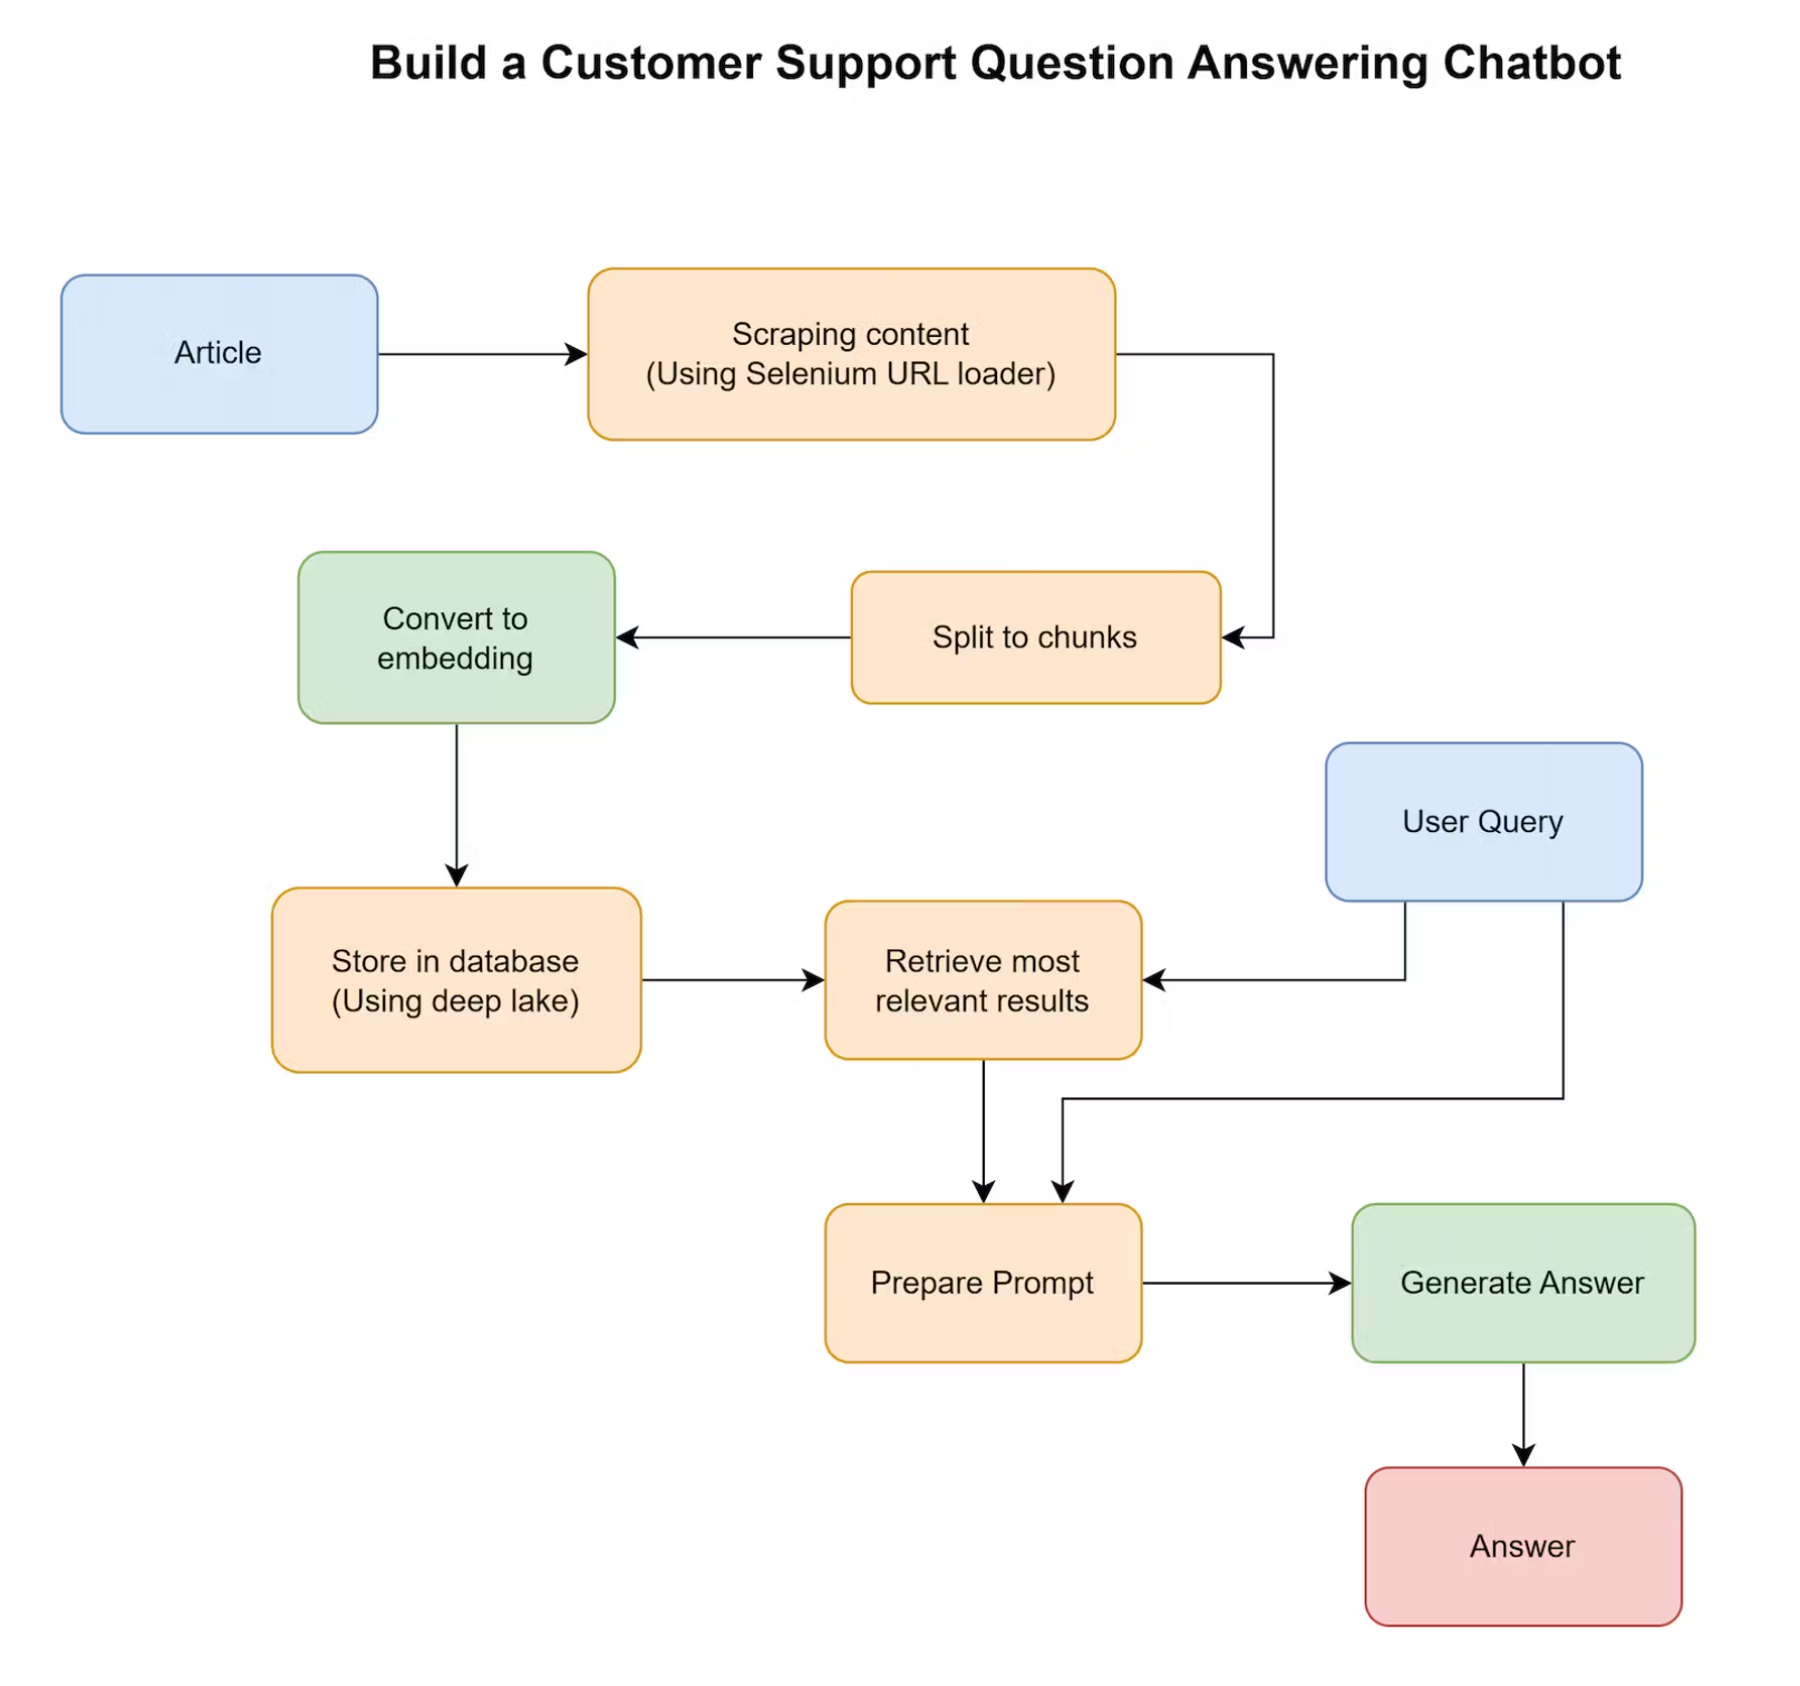


First we scrape some content from online articles, we split them into small chunks, compute their embeddings and store them in Deep Lake. Then, we use a user query to retrieve the most relevant chunks from Deep Lake, we put them into a prompt, which will be used to generate the final answer by the LLM.

It is important to note that there is always a risk of generating hallucinations or false information when using LLMs. Although this might not be acceptable for many customers support use cases, the chatbot can still be helpful for assisting operators in drafting answers that they can double-check before sending them to the user.

In [ ]:
!pip install langchain==0.0.208 deeplake openai tiktoken

In [2]:
from getpass import getpass
import os
os.environ["OPENAI_API_KEY"] = getpass()

··········


In [3]:
from getpass import getpass
import os
os.environ["ACTIVELOOP_TOKEN"] = getpass()

··········


In [4]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import DeepLake
from langchain.text_splitter import CharacterTextSplitter
from langchain import OpenAI
from langchain.document_loaders import SeleniumURLLoader
from langchain import PromptTemplate

These libraries provide functionality for handling OpenAI embeddings, managing vector storage, splitting text, and interacting with the OpenAI API. They also enable the creation of a context-aware question-answering system, incorporating retrieval and text generation.

The database for our chatbot will consist of articles regarding technical issues.

In [5]:
# we'll use information from the following articles
urls = ['https://beebom.com/what-is-nft-explained/',
        'https://beebom.com/how-delete-spotify-account/',
        'https://beebom.com/how-download-gif-twitter/',
        'https://beebom.com/how-use-chatgpt-linux-terminal/',
        'https://beebom.com/how-delete-spotify-account/',
        'https://beebom.com/how-save-instagram-story-with-music/',
        'https://beebom.com/how-install-pip-windows/',
        'https://beebom.com/how-check-disk-usage-linux/']

## **1: Split the documents into chunks and compute their embeddings:**
We load the documents from the provided URLs and split them into chunks using the `CharacterTextSplitter` with a chunk size of 1000 and no overlap:

In [ ]:
%%shell

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

In [ ]:
!apt-get update
!apt-get install chromium chromium-driver

In [ ]:
!pip install unstructured selenium

In [10]:
from selenium import webdriver

def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

In [11]:
driver = web_driver()

driver.get('https://www.google.com')

driver.quit()

In [14]:
# use the selenium scraper to load the documents
loader = SeleniumURLLoader(urls=urls)
docs_not_splitted = loader.load()

# we split the documents into smaller chunks
text_splitter = CharacterTextSplitter(chunk_size=1250, chunk_overlap=0)
docs = text_splitter.split_documents(docs_not_splitted)

Next, we compute the embeddings using OpenAIEmbeddings and store them in a Deep Lake vector store on the cloud. In an ideal production scenario, we could upload a whole website or course lesson on a Deep Lake dataset, allowing for search among even thousands or millions of documents. As we are using a cloud serverless Deep Lake dataset, applications running on different locations can easily access the same centralized dataset without the need of deploying a vector store on a custom machine.

Let’s now modify the following code by adding your Activeloop organization ID. It worth noting that the org id is your username by default.



In [ ]:
# Before executing the following code, make sure to have
# your OpenAI key saved in the “OPENAI_API_KEY” environment variable.
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

# create Deep Lake dataset
# TODO: use your organization id here. (by default, org id is your username)
my_activeloop_org_id = "dasarpan007"
my_activeloop_dataset_name = "langchain_course_customer_support"
dataset_path = f"hub://{my_activeloop_org_id}/{my_activeloop_dataset_name}"
db = DeepLake(dataset_path=dataset_path, embedding_function=embeddings)

# add documents to our Deep Lake dataset
db.add_documents(docs)

To retrieve the most similar chunks to a given query, we can use the similarity_search method of the Deep Lake vector store:

In [16]:
# let's see the top relevant documents to a specific query
query = "how to check disk usage in linux?"
docs = db.similarity_search(query)
print(docs[0].page_content)

Home  Tech  How to Check Disk Usage in Linux (4 Methods)

How to Check Disk Usage in Linux (4 Methods)

Beebom Staff

Last Updated: June 19, 2023 5:14 pm

There may be times when you need to download some important files or transfer some photos to your Linux system, but face a problem of insufficient disk space. You head over to your file manager to delete the large files which you no longer require, but you have no clue which of them are occupying most of your disk space. In this article, we will show some easy methods to check disk usage in Linux from both the terminal and the GUI application.

Monitor Disk Usage in Linux (2023)

Table of Contents

Check Disk Space Using the df Command
		
Display Disk Usage in Human Readable FormatDisplay Disk Occupancy of a Particular Type

Check Disk Usage using the du Command
		
Display Disk Usage in Human Readable FormatDisplay Disk Usage for a Particular DirectoryCompare Disk Usage of Two Directories

Clean Disk Space Using the Command Line
		
S

## **2: Craft a prompt for GPT-3 using the suggested strategies**
We will create a prompt template that incorporates role-prompting, relevant Knowledge Base information, and the user's question:

In [17]:
# let's write a prompt for a customer support chatbot that
# answer questions using information extracted from our db
template = """You are an exceptional customer support chatbot that gently answer questions.

You know the following context information.

{chunks_formatted}

Answer to the following question from a customer. Use only information from the previous context information. Do not invent stuff.

Question: {query}

Answer:"""

prompt = PromptTemplate(
    input_variables=["chunks_formatted", "query"],
    template=template,
)

The template sets the chatbot's persona as an exceptional customer support chatbot. The template takes two input variables: `chunks_formatted`, which consists of the pre-formatted chunks from articles, and `query`, representing the customer's question. The objective is to generate an accurate answer using only the provided chunks without creating any false or invented information.

## **3: Utilize the GPT3 model with a temperature of 0 for text generation**
To generate a response, we first retrieve the top-k (e.g., top-3) chunks most similar to the user query, format the prompt, and send the formatted prompt to the GPT3 model with a temperature of 0.

In [18]:
# the full pipeline

# user question
query = "How to check disk usage in linux?"

# retrieve relevant chunks
docs = db.similarity_search(query)
retrieved_chunks = [doc.page_content for doc in docs]

# format the prompt
chunks_formatted = "\n\n".join(retrieved_chunks)
prompt_formatted = prompt.format(chunks_formatted=chunks_formatted, query=query)

# generate answer
llm = OpenAI(model="text-davinci-003", temperature=0)
answer = llm(prompt_formatted)
print(answer)

 You can check disk usage in Linux using the df command in the terminal or using the Gnome Disk Tool or Disk Usage Analyzer Tool in the GUI. The df command shows the sizes in bytes, which may be hard for some people to read. To see file sizes in a human-readable format such as megabytes, gigabytes, etc., then use the -h flag. The Gnome disk utility tool is generally used to format storage partitions to a specific type. The Disk Usage Analyzer Tool is a useful tool to monitor disk usage in the GUI.


## **Issues with Generating Answers using GPT-3**
In the previous example, the chatbot generally performs well. However, there are certain situations where it could fail.

Suppose we ask, "Is the Linux distribution free?" and provide GPT-3 with a document about kernel features as context. It might generate an answer like "Yes, the Linux distribution is free to download and use," even if such information is not present in the context document. Producing false information is highly undesirable for customer service chatbots!

GPT-3 is less likely to generate false information when the answer to the user's question is contained within the context. Since user questions are often brief and ambiguous, we cannot always rely on the semantic search step to retrieve the correct document. Thus, there is always a risk of generating false information.

## **Conclusion**
GPT-3 is highly effective in creating conversational chatbots capable of answering specific questions based on the contextual information provided in the prompt. However, it can be challenging to ensure that the model generates answers solely based on the context, as it has a tendency to hallucinate (i.e., generate new, potentially false information). The severity of generating false information varies depending on the use case.

To conclude, we implemented a context-aware question-answering system using LangChain, following the provided code and strategies. The process involved splitting documents into chunks, computing their embeddings, implementing a retriever to find similar chunks, crafting a prompt for GPT-3, and using the GPT3 model for text generation. This approach demonstrates the potential of leveraging GPT-3 to create powerful and contextually accurate chatbots while also highlighting the need to be cautious about the possibility of generating false information.

In the next lesson, you’ll see how to leverage Deep Lake and GPT-4 for building a sales assistant.